# **Ф35**: Модуль прогнозирования эффектов трансформации территории в масштабах населенного пункта и региона

## 1. Подготовка исходных данных

- `service_types` -- таблица типов сервисов.
- `blocks` -- слой городских кварталов с разной информацией.
- `acc_mx` -- матрица доступности городских кварталов.

In [32]:
import pandas as pd
import geopandas as gpd
from blocksnet.config import log_config

log_config.set_disable_tqdm(True)
log_config.set_logger_level('ERROR')

service_types = pd.read_pickle('./data/service_types.pickle')
blocks = pd.read_pickle('./data/blocks.pickle')
acc_mx = pd.read_pickle('./data/acc_mx.pickle')

In [33]:
blocks['population'] = blocks['population'].fillna(0)

### 1.1. Подготовка списка сервисов

Нужны только те списки сервисов, у которых есть `infrastructure_type`

In [34]:
service_types = service_types[~service_types['infrastructure_type'].isna()].copy()
service_types.head()

,name,infrastructure_type,infrastructure_weight,social_values
service_type_id,,,,
1,park,basic,0.2,[8]
5,beach,comfort,0.5,None
21,kindergarten,basic,0.2,[2]
22,school,basic,0.2,"[2, 4]"
27,university,comfort,0.2,"[4, 10, 17]"


## 2A. Эффекты ДО

Если `scenario_id` является `base_scenario`, то мы не обязаны ничего оптимизировать и просто должны посчитать обеспеченность as is.

In [35]:
from blocksnet.relations.accessibility import get_accessibility_context

def _get_accessibility_context(blocks : pd.DataFrame, acc_mx : pd.DataFrame, accessibility : float) -> list[int]:
  project_blocks = blocks[blocks['is_project']].copy()
  context_blocks = get_accessibility_context(acc_mx, project_blocks, accessibility, out=False, keep=True)
  return list(context_blocks.index)

In [36]:
from blocksnet.analysis.provision import competitive_provision
from blocksnet.config import service_types_config

def _assess_provision(blocks : pd.DataFrame, acc_mx : pd.DataFrame, service_type : str) -> gpd.GeoDataFrame:
  _, demand, accessibility = service_types_config[service_type].values()
  context_ids = _get_accessibility_context(blocks, acc_mx, accessibility)
  capacity_column = f'capacity_{service_type}'
  if capacity_column not in blocks.columns:
    blocks_df = blocks[['geometry','population']].fillna(0)
    blocks_df['capacity'] = 0
  else:
    blocks_df = blocks.rename(columns={capacity_column:'capacity'})[['geometry', 'population', 'capacity']].fillna(0)
  prov_df, _ = competitive_provision(blocks_df, acc_mx, accessibility, demand)
  prov_df = prov_df.loc[context_ids].copy()
  return blocks[['geometry']].join(prov_df, how='right')

### Получаем слои с оценкой обеспеченности

In [37]:
from blocksnet.config import service_types_config

prov_gdfs = {}
for st_id in service_types.index:
    st_name = service_types.loc[st_id,'name']
    column = f'capacity_{st_name}'
    _,demand,accessibility = service_types_config[st_name].values()
    prov_gdf = _assess_provision(blocks, acc_mx, st_name)
    prov_gdfs[st_name] = prov_gdf

Например:

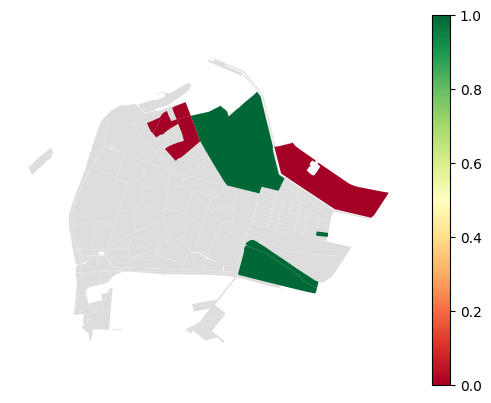

In [38]:
ax = prov_gdfs['school'].plot(color='#ddd')
prov_gdfs['school'].plot('provision_strong', ax=ax, vmin=0, vmax=1, cmap='RdYlGn', legend=True).set_axis_off()

### Получаем общие оценки обеспеченности

In [39]:
from blocksnet.analysis.provision import competitive_provision, provision_strong_total

prov_totals = {}
for st_name, prov_gdf in prov_gdfs.items():
    if prov_gdf.demand.sum() == 0:
        total = None
    else:
        total = float(provision_strong_total(prov_gdf))
    prov_totals[st_name] = total

В итоге:

In [40]:
prov_totals

{'park': 1.0,
 'beach': 0.0,
 'kindergarten': 0.0,
 'school': 0.674074074074074,
 'university': 0.0,
 'polyclinic': 0.0,
 'pharmacy': 1.0,
 'hospital': 0.5707547169811321,
 'library': 1.0,
 'museum': 0.9856115107913669,
 'theatre': 0.0,
 'cinema': 0.0,
 'mall': 0.8875,
 'stadium': 0.19327731092436976,
 'cafe': 1.0,
 'restaurant': 0.6990838618745595,
 'bar': 0.4642857142857143,
 'pitch': 1.0,
 'playground': None,
 'police': 0.4,
 'train_station': 0.3865546218487395,
 'supermarket': 0.9897209985315712,
 'market': 0.6977599465061852,
 'bank': 1.0,
 'veterinary': 0.711864406779661,
 'hotel': 1.0,
 'religion': 0.6984924623115578,
 'sanatorium': 0.0}

### Результат

В результате имеем следующие данные для ситуации ДО:
- `prov_gdfs : dict[str, gpd.GeoDataFrame]` -- слои с оценкой обеспеченности по выбранным типам сервисов
- `prov_totals : dict[str, float | None]` -- оценки обеспеченности

## 2B. Эффекты ПОСЛЕ

Если `scenario_id` не является `base_scenario`, то для заданного пользователем функционального зонирования мы должны предсказать возможную обеспеченность (по сути, лучший случай).

### Подготовка данных

Для каждого `infrastructure_type` также добавим весовой коэффициент, чтобы отдать предпочтение базовым сервисам, а остальные добавлять по возможности.

In [41]:
INFRASTRUCTURES_WEIGHTS = {
    'basic': 0.5714,
    'additional': 0.2857,
    'comfort': 0.1429
}

service_types['infrastructure_weight'] = service_types['infrastructure_type'].map(INFRASTRUCTURES_WEIGHTS) * service_types['infrastructure_weight']
service_types.head()

,name,infrastructure_type,infrastructure_weight,social_values
service_type_id,,,,
1,park,basic,0.11428,[8]
5,beach,comfort,0.07145,None
21,kindergarten,basic,0.11428,[2]
22,school,basic,0.11428,"[2, 4]"
27,university,comfort,0.02858,"[4, 10, 17]"


Готовим словарь, какой квартал в какой ФЗ переводим.

`blocks_lus : dict[int, LandUse]`

In [42]:
blocks_lus = blocks.loc[blocks['is_project'],'land_use']
blocks_lus = blocks_lus[~blocks_lus.isna()]
blocks_lus = blocks_lus.to_dict()

Инициализируем экземпляр класса оптимизатора.

In [43]:
from blocksnet.optimization.services import (
    TPEOptimizer,
    WeightedObjective,
    WeightedConstraints,
    Facade,
    BlockSolution,
    SimpleChooser,
    GradientChooser,
    AreaSolution
)

var_adapter = AreaSolution(blocks_lus)

facade = Facade(
    blocks_lu=blocks_lus,
    blocks_df=blocks,
    accessibility_matrix=acc_mx,
    var_adapter=var_adapter,
)


Добавляем информацию о существующих типах сервисов.

**ВАЖНО**: если сервиса нет в слое кварталов, просто добавляем `DataFrame` с нулевыми `capacity` для него. Ведь мы же должны что-то расставлять.

ЛИБО

Можно попробовать на этапе сборки слоя просто добавлять пустой столбец, чтобы не терять.

In [44]:
for st_id, row in service_types.iterrows():
    st_name = row['name']
    st_weight = row['infrastructure_weight']
    st_column = f'capacity_{st_name}'
    if st_column in blocks.columns:
        df = blocks.rename(columns={st_column: 'capacity'})[['capacity']].fillna(0)
    else:
        print(f'#{st_id}:{st_name} нет на территории контекста проекта. Добавляем нулевой датафрейм')
        df = blocks[[]].copy()
        df['capacity'] = 0
    facade.add_service_type(st_name, st_weight, df)

#5:beach нет на территории контекста проекта. Добавляем нулевой датафрейм
#51:theatre нет на территории контекста проекта. Добавляем нулевой датафрейм
#56:cinema нет на территории контекста проекта. Добавляем нулевой датафрейм
#143:sanatorium нет на территории контекста проекта. Добавляем нулевой датафрейм


### Оптимизация

Запускаем оптимизатор...

In [47]:
services_weights = service_types.set_index('name')['infrastructure_weight'].to_dict()

objective = WeightedObjective(num_params=facade.num_params, facade=facade, weights=services_weights, max_evals=50)

constraints = WeightedConstraints(num_params=facade.num_params, facade=facade)

tpe_optimizer = TPEOptimizer(
    objective=objective, constraints=constraints, vars_chooser=SimpleChooser(facade)
)

best_x, best_val, perc, func_evals = tpe_optimizer.run(max_runs=50, timeout=60000, initial_runs_num=1)

  0%|          | 0/50 [00:00<?, ?it/s]

/home/vasilstar/prostor-examples/.venv/lib/python3.10/site-packages/optuna/trial/_trial.py:652: UserWarning: Fixed parameter 'x_174' with value 1249 is out of range for distribution IntDistribution(high=426, log=False, low=0, step=1).
  warnings.warn(
/home/vasilstar/prostor-examples/.venv/lib/python3.10/site-packages/optuna/trial/_trial.py:652: UserWarning: Fixed parameter 'x_176' with value 1252 is out of range for distribution IntDistribution(high=612, log=False, low=0, step=1).
  warnings.warn(
/home/vasilstar/prostor-examples/.venv/lib/python3.10/site-packages/optuna/trial/_trial.py:652: UserWarning: Fixed parameter 'x_318' with value 1762 is out of range for distribution IntDistribution(high=23, log=False, low=0, step=1).
  warnings.warn(
/home/vasilstar/prostor-examples/.venv/lib/python3.10/site-packages/optuna/trial/_trial.py:652: UserWarning: Fixed parameter 'x_324' with value 1762 is out of range for distribution IntDistribution(high=820, log=False, low=0, step=1).
  warnings

### Результат

Если для данного типа сервиса все хорошо в плане обеспеченности с самого начала, то он не оптимизируется и для него обеспеченность считается той же, что и раньше.

In [48]:
prov_gdfs = {}
for st_id in service_types.index:
    st_name = service_types.loc[st_id, 'name']
    if st_name in facade._chosen_service_types:
        prov_df = facade._provision_adapter.get_last_provision_df(st_name)
        prov_gdf = blocks[['geometry']].join(prov_df, how='right')
        prov_gdfs[st_name] = prov_gdf

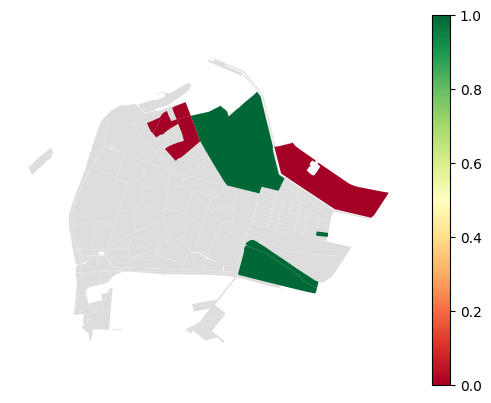

In [49]:
ax = prov_gdfs['school'].plot(color='#ddd')
prov_gdfs['school'].plot('provision_strong', ax=ax, vmin=0, vmax=1, cmap='RdYlGn', legend=True).set_axis_off()

Чиселки обеспеченности для графика

In [51]:
prov_totals = {}
for st_name, prov_gdf in prov_gdfs.items():
    if prov_gdf.demand.sum() == 0:
        total = None
    else:
        total = float(provision_strong_total(prov_gdf))
    prov_totals[st_name] = total

Если какой-то сервис тут отсутствует, можно брать с `base_scenario` (?? я подумаю еще правильно ли это)

In [52]:
prov_totals

{'beach': 0.0,
 'kindergarten': 0.0,
 'school': 0.674074074074074,
 'university': 0.0,
 'polyclinic': 0.3333333333333333,
 'hospital': 1.0,
 'museum': 1.0,
 'theatre': 0.9469964664310954,
 'cinema': 0.0,
 'mall': 0.8875,
 'stadium': 0.19327731092436976,
 'restaurant': 1.0,
 'bar': 0.4642857142857143,
 'police': 1.0,
 'train_station': 0.9425770308123249,
 'supermarket': 0.9926578560939795,
 'market': 0.808090939485122,
 'veterinary': 0.8135593220338984,
 'religion': 1.0,
 'sanatorium': 0.0}

# **Ф26**: Модуль ценностно-ориентированного моделирования программ развития населенного пункта.

Берем результат из пункта `2.b` и разворачиваем его на кварталы: куда что ставить:

- `block_id` -- номер квартала, куда ставим.
- `service_type` -- тип сервиса.
- `site_area` -- занимаемая площадь квартала.
- `build_floor_area` -- занимаемая площадь зданий.
- `capacity` -- суммарная емкость типа застройки
- `count` -- количество расставляемых объектов данного типа в данном квартале

P.S: сейчас результаты не выглядят правдиво. Оптимизатор дорабатывается, формат останется таким же.

In [50]:
solution_df = facade.solution_to_services_df(best_x)
solution_df

,block_id,service_type,site_area,build_floor_area,capacity,count
361,10,polyclinic,0.0,700.0,100,1
366,11,polyclinic,0.0,400.0,50,1
373,12,polyclinic,0.0,700.0,100,1
379,17,polyclinic,0.0,700.0,100,1
385,19,polyclinic,0.0,700.0,100,1
...,...,...,...,...,...,...
2073,17,religion,9100.0,2000.0,1300,2
2081,20,religion,9100.0,2000.0,1300,2
2109,33,religion,9100.0,2000.0,1300,1
2113,34,religion,9100.0,2000.0,1300,2
